In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import sklearn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding

sys.path.insert(1, os.path.join(sys.path[0], ".."))
sys.path.append('../../')
from reproduction.pipeline import load as pipeline
from reproduction import analysis
from reproduction.analysis import AEData

In [2]:
model_dir = "/home/rlourenco/rdcep_clouds/output/m9cnn21-dse-henso/"

with open(model_dir + "encoder.json", "r") as f:
    ae = tf.keras.models.model_from_json(f.read())
ae.load_weights(model_dir + "encoder.h5")

/home/rlourenco/miniconda3/envs/clouds-analysis-cpu/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:764: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


In [3]:
data = AEData(
    dataset=pipeline.load_data(
        data_glob="/project/foster/clouds/data/2015_05/*.tfrecord",
        shape=(128, 128, 7),
        batch_size=32,
        read_threads=4,
        shuffle_buffer_size=100,
        prefetch=2
    ),
    fields=["b%d"%(i+1) for i in range(7)],
    n=3000
)

Instructions for updating:
Use `tf.data.Dataset.batch(..., drop_remainder=True)`.


# PCA Anaysis

In [4]:
model_dir = "/home/rlourenco/rdcep_clouds/output/m9cnn21-dse-henso/"

def load_model(mname, summary=True):
    with open(mname + ".json", "r") as f:
        m = tf.keras.models.model_from_json(f.read())
    m.load_weights(mname + ".h5")
    m.summary()
    return m  

encoder = load_model(model_dir + "encoder")
decoder = load_model(model_dir + "decoder")

data.raw_encs = encoder.predict(data.imgs)
print('raw_encs: ',data.raw_encs.shape)
data.ae_imgs = decoder.predict(data.raw_encs)
print('ae_imgs: ',data.ae_imgs.shape)
data.encs = data.ae_imgs.mean(axis=(1,2))
print('encs: ',data.encs.shape)
data.compute_pca()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 7)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 8)  512         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    584         leaky_re_lu[0][0]                
__________________________________________________________________________________________________
leaky_re_l

raw_encs:  (3000, 1024)
ae_imgs:  (3000, 128, 128, 7)
encs:  (3000, 7)


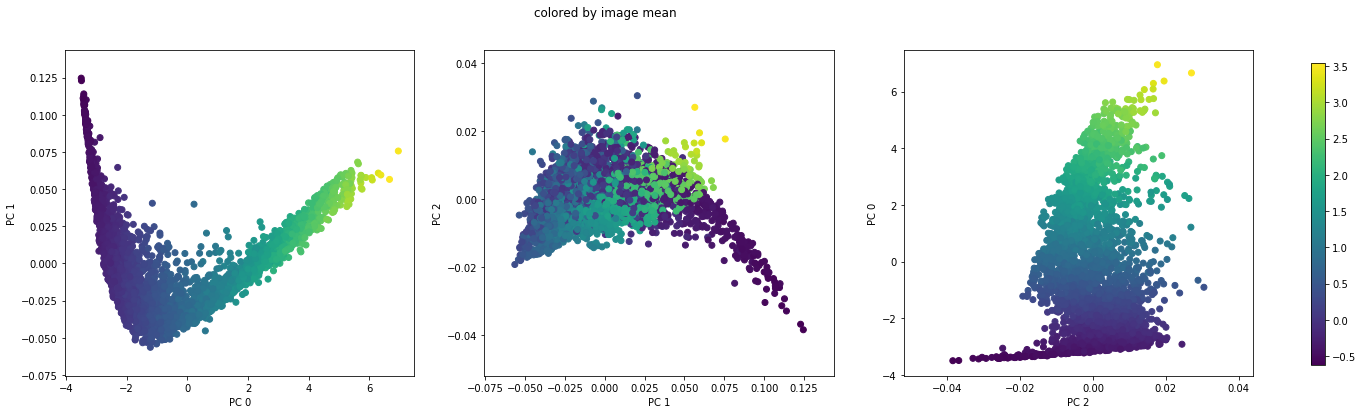

In [5]:
data.plot_pca_projection(data.encs, "colored by image mean", width=6, c=data.imgs.mean(axis=(1,2,3)))

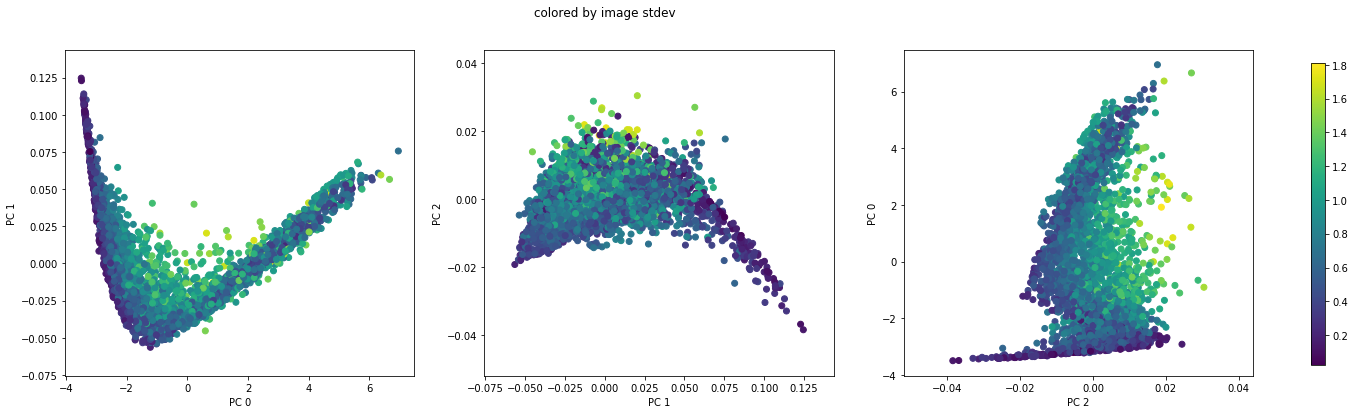

In [6]:
data.plot_pca_projection(data.encs, "colored by image stdev", width=6, c=data.imgs.std(axis=(1,2,3)))

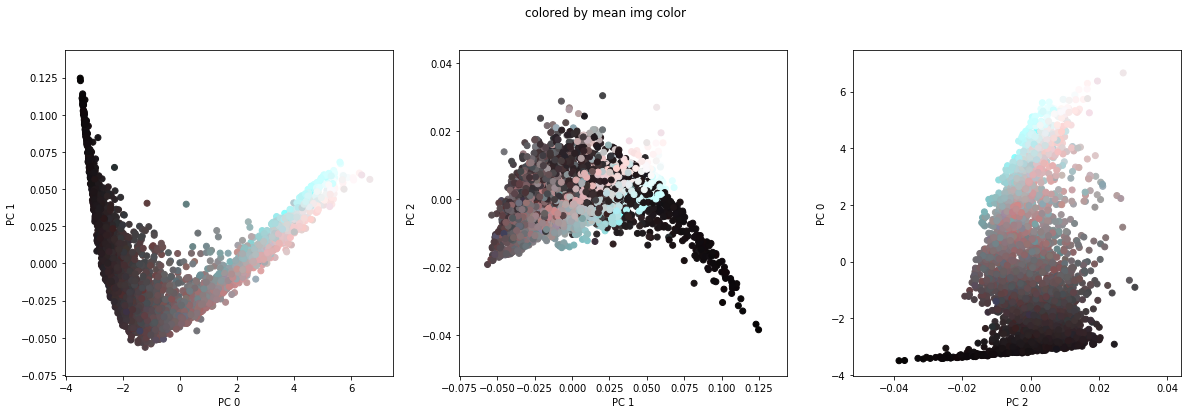

In [7]:
data.plot_pca_projection(
    data.encs, "colored by mean img color", width=6, cbar=False,
    color=data.colored_imgs.mean(axis=(1,2))
)

In [8]:
data.encs.shape

(3000, 7)

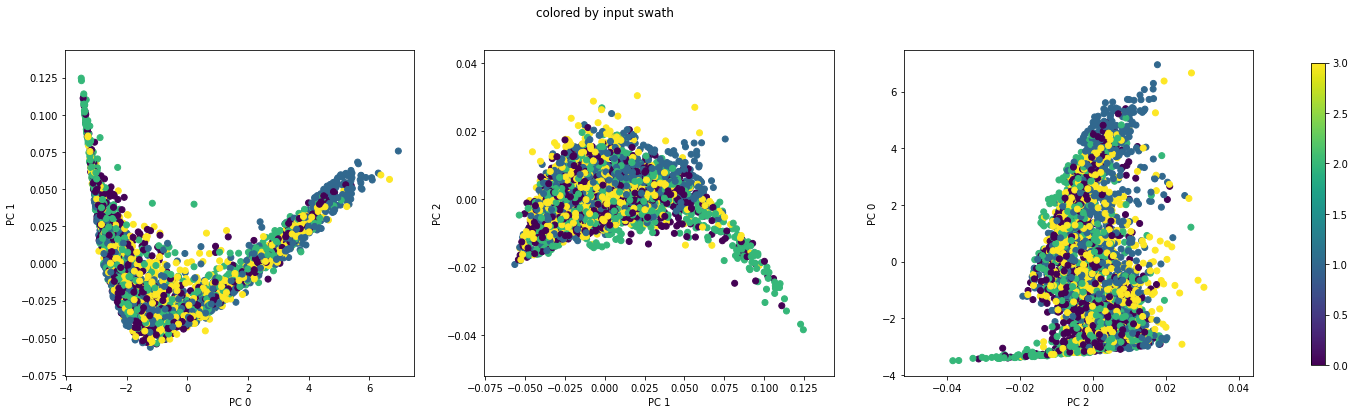

In [9]:
%matplotlib inline
lmap = {n: i for i,n in enumerate(set(data.names))}
label = [lmap[l] for l in data.names]
data.plot_pca_projection(data.encs, "colored by input swath", width=6, c=label[:3000])

In [10]:
def colored_embedding(emb, titles_and_kwargs, nrows=2, ncols=2, width=6):
    fig = plt.figure(figsize=(width * nrows , width * ncols))
    
    for i, (tit, kwargs) in enumerate(titles_and_kwargs):
        a = fig.add_subplot(nrows, ncols, i+1, projection="3d")
        a.scatter(*emb.T, **kwargs)
        a.set_title(tit)

In [11]:
main_plots =  [
    ("colored by patch mean", {"c": data.imgs.mean(axis=(1,2,3))}),
    ("colored by patch stdev", {"c": data.imgs.std(axis=(1, 2, 3))}),
    ("colored by swath", {"c": label[:3000]}),
    ("colored by mean img color", {"color": data.colored_imgs.mean(axis=(1,2))})
]

<IPython.core.display.Javascript object>


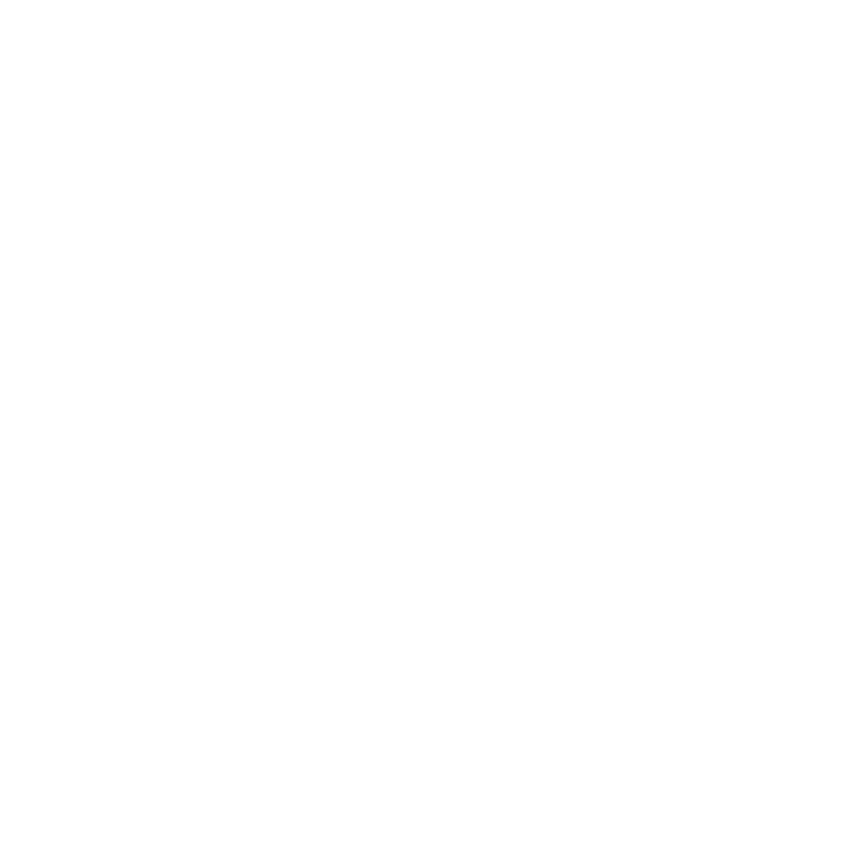

In [12]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook

colored_embedding(data.pca_project(data.encs).T, main_plots)

## IsoMap

In [13]:
isomap_emb = Isomap(n_components=3).fit_transform(data.encs)

<IPython.core.display.Javascript object>


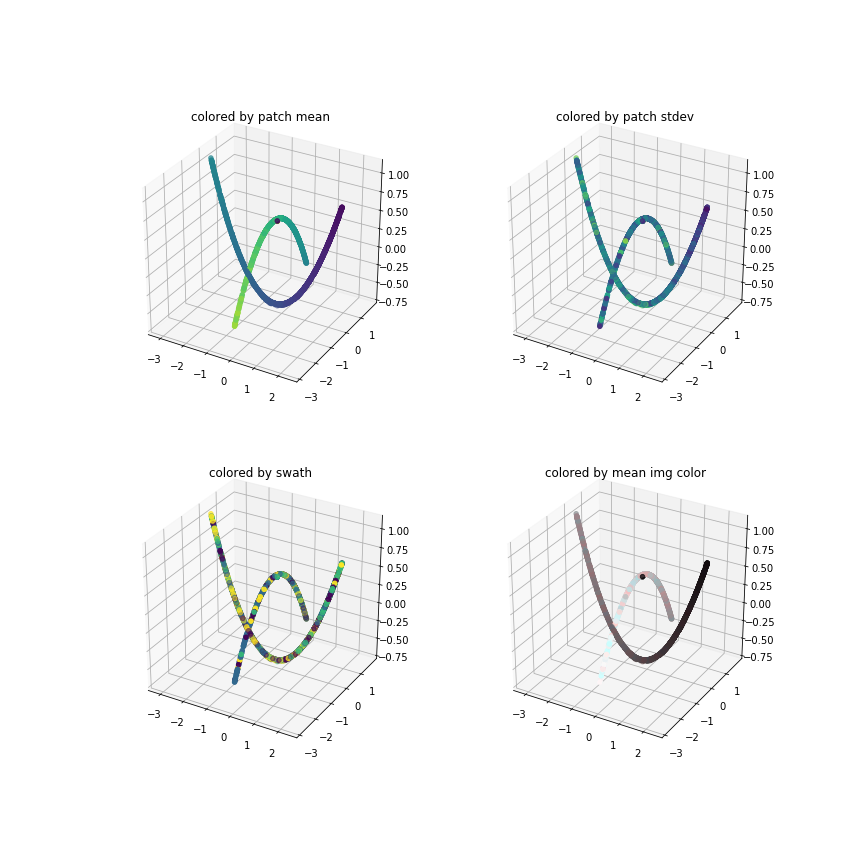

In [14]:
%matplotlib notebook
%matplotlib notebook

colored_embedding(isomap_emb, main_plots)

## TSNE Embedding

In [15]:
tsne_emb = TSNE(n_components=3).fit_transform(data.encs)

<IPython.core.display.Javascript object>


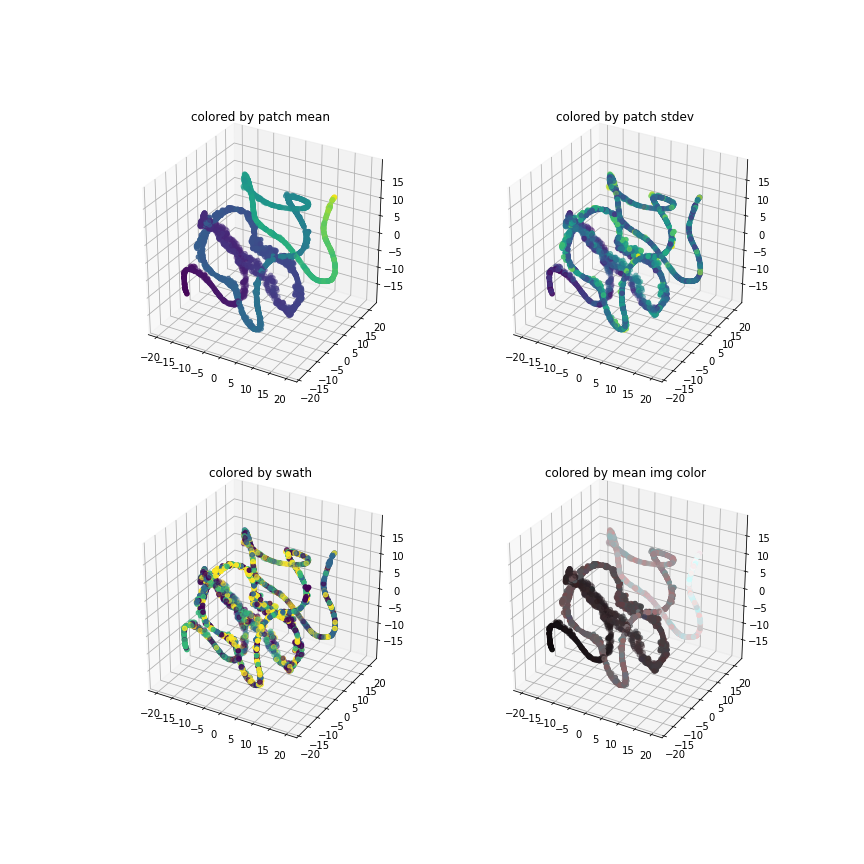

In [16]:
colored_embedding(tsne_emb, main_plots)

## Spectral Embedding

In [17]:
spectral_emb = SpectralEmbedding(n_components=3).fit_transform(data.encs)

<IPython.core.display.Javascript object>


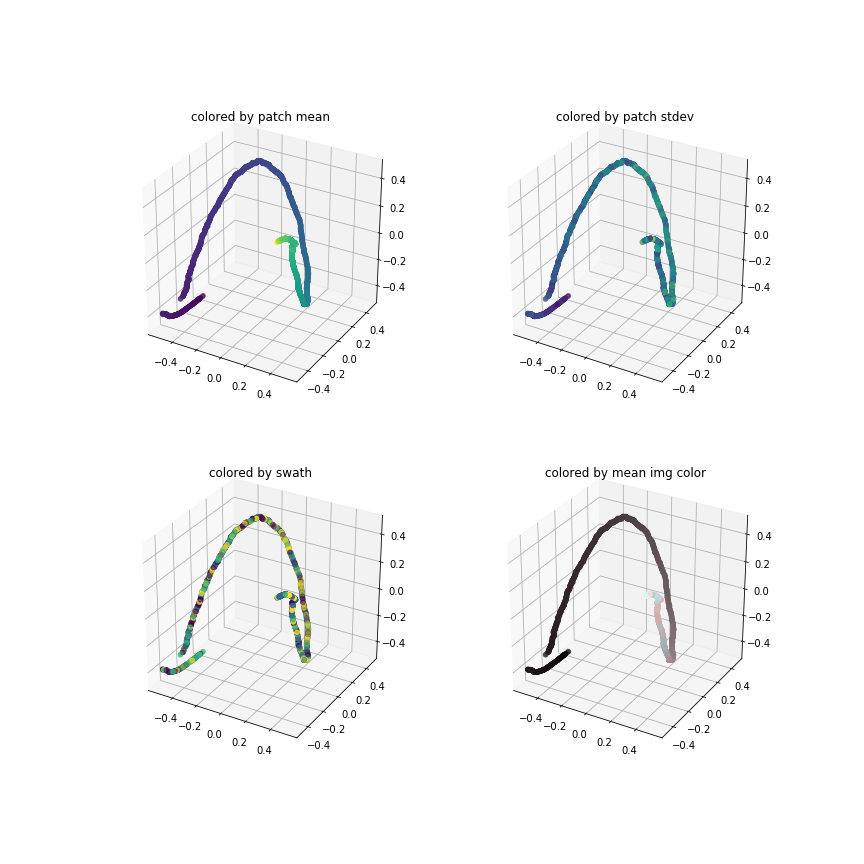

In [18]:
colored_embedding(spectral_emb, main_plots)